In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import PorterStemmer
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamW

c:\Users\Niko Silabest\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

# Ganti 'nama_file.xlsx' dengan nama file Excel yang ingin Anda baca
nama_file = 'Data_Updated_with_Labels.xlsx'

# Membaca file Excel ke dalam DataFrame Pandas
df = pd.read_excel(nama_file)


In [3]:
df.head(5)

,File Name,No Putusan,Lembaga Peradilan,Pokok Gugatan,Amar Putusan,Label
0,putusan_1003_pdt.g_2023_pn_sby_20231229202339....,Nomor 1003/Pdt.G/2023/PN,Pengadilan Negeri Surabaya,gugatan Penggugat Menimbang bahwa permohonan p...,persidangan pada tanggal 10 Oktober 2023 yan...,tidak sesuai
1,putusan_100_pdt.p_2023_pn_bjm_20231230015012.p...,Nomor 100/Pdt.P/2023/PN Bjm,Pengadilan Negeri Banjarmasin,False,M E N E T A P K A N 1. Mengabulkan permohonan...,tidak sesuai
2,putusan_101_pdt.g_2022_pn_bjm_20231230021018.p...,Nomor 101/Pdt.G/2022/PN Bjm,Pengadilan Negeri Banjarmasin,"gugatan antara: SARI JAYALANA, Lahir di Banjar...",MENGADILI: Dalam Eksepsi − Menolak eksepsi dar...,sesuai
3,putusan_101_pdt.p_2023_pn_bjm_20231230014140.p...,Nomor 101/Pdt.P/2023/PN Bjm,Pengadilan Negeri Banjarmasin,False,Menetapkan dan memberikan izin kepada Pemohon...,tidak sesuai
4,putusan_1021_pdt.g_2022_pn_jkt.brt_20231229200...,Nomor 1021/Pdt.G/2022/PN Jkt,Pengadilan Negeri Jakarta,gugatan antara: PT Mandiri Utama Finance Finan...,Demikian diputuskan dalam sidang pemusyawarata...,sesuai


In [4]:
df.dtypes

File Name            object
No Putusan           object
Lembaga Peradilan    object
Pokok Gugatan        object
Amar Putusan         object
Label                object
dtype: object

In [5]:
stop_words = set(stopwords.words('indonesian'))
ps = PorterStemmer()

In [6]:
import re

def preprocess_text(text):
    # Case folding
    text = text.lower()
    
    # Hapus karakter selain huruf
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    
    # Stemming
    text = ' '.join([ps.stem(word) for word in text.split()])
    
    return text

In [7]:
df['Amar Putusan'] = df['Amar Putusan'].apply(preprocess_text)

In [8]:
encoder = LabelEncoder()
df['labels'] = encoder.fit_transform(df['Label'])

In [9]:
df.head(5)

,File Name,No Putusan,Lembaga Peradilan,Pokok Gugatan,Amar Putusan,Label,labels
0,putusan_1003_pdt.g_2023_pn_sby_20231229202339....,Nomor 1003/Pdt.G/2023/PN,Pengadilan Negeri Surabaya,gugatan Penggugat Menimbang bahwa permohonan p...,persidangan tanggal oktob isinya pokoknya menc...,tidak sesuai,1
1,putusan_100_pdt.p_2023_pn_bjm_20231230015012.p...,Nomor 100/Pdt.P/2023/PN Bjm,Pengadilan Negeri Banjarmasin,False,m e n e t a p k a n mengabulkan permohonan pem...,tidak sesuai,1
2,putusan_101_pdt.g_2022_pn_bjm_20231230021018.p...,Nomor 101/Pdt.G/2022/PN Bjm,Pengadilan Negeri Banjarmasin,"gugatan antara: SARI JAYALANA, Lahir di Banjar...",mengadili eksepsi menolak eksepsi tergugat ii ...,sesuai,0
3,putusan_101_pdt.p_2023_pn_bjm_20231230014140.p...,Nomor 101/Pdt.P/2023/PN Bjm,Pengadilan Negeri Banjarmasin,False,menetapkan izin pemohon ganti nama akta kelahi...,tidak sesuai,1
4,putusan_1021_pdt.g_2022_pn_jkt.brt_20231229200...,Nomor 1021/Pdt.G/2022/PN Jkt,Pengadilan Negeri Jakarta,gugatan antara: PT Mandiri Utama Finance Finan...,diputuskan sidang pemusyawaratan maje hakim pe...,sesuai,0


In [10]:
df.dtypes

File Name            object
No Putusan           object
Lembaga Peradilan    object
Pokok Gugatan        object
Amar Putusan         object
Label                object
labels                int32
dtype: object

In [11]:
# Membagi data menjadi set pelatihan dan pengujian menggunakan train_test_split.
X_train, X_test, y_train, y_test = train_test_split(df['Amar Putusan'].to_list(), df['labels'], test_size=0.2, random_state=111)

In [12]:
# Load model directly
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

c:\Users\Niko Silabest\anaconda3\envs\tf_gpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128, return_tensors="tf")
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128,return_tensors="tf")

In [14]:
import tensorflow as tf

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [16]:
model = TFBertForSequenceClassification.from_pretrained('nlpaueb/legal-bert-base-uncased', num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])


In [18]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 patience=10, 
                                                 restore_best_weights=True)

In [19]:
with tf.device('/CPU:0'):
    history = model.fit(train_dataset.batch(10), epochs=50, validation_data=test_dataset.batch(10), batch_size=10, callbacks=[early_stopper])

Epoch 1/50
30/30 [==============================] - 131s 4s/step - loss: 0.4891 - accuracy: 0.8076 - val_loss: 0.2688 - val_accuracy: 0.9041
Epoch 2/50
30/30 [==============================] - 103s 3s/step - loss: 0.1888 - accuracy: 0.9759 - val_loss: 0.1734 - val_accuracy: 0.9589
Epoch 3/50
30/30 [==============================] - 104s 3s/step - loss: 0.0869 - accuracy: 0.9931 - val_loss: 0.1712 - val_accuracy: 0.9589
Epoch 4/50
30/30 [==============================] - 103s 3s/step - loss: 0.0605 - accuracy: 0.9897 - val_loss: 0.1745 - val_accuracy: 0.9589
Epoch 5/50
30/30 [==============================] - 103s 3s/step - loss: 0.0526 - accuracy: 0.9897 - val_loss: 0.1873 - val_accuracy: 0.9589
Epoch 6/50
30/30 [==============================] - 103s 3s/step - loss: 0.0349 - accuracy: 0.9966 - val_loss: 0.1506 - val_accuracy: 0.9589
Epoch 7/50
30/30 [==============================] - 101s 3s/step - loss: 0.0285 - accuracy: 0.9931 - val_loss: 0.1666 - val_accuracy: 0.9589
Epoch 8/50
30

penjelasan mengenai pembahasan hasil, mengapa mendapat grafik tersebut.

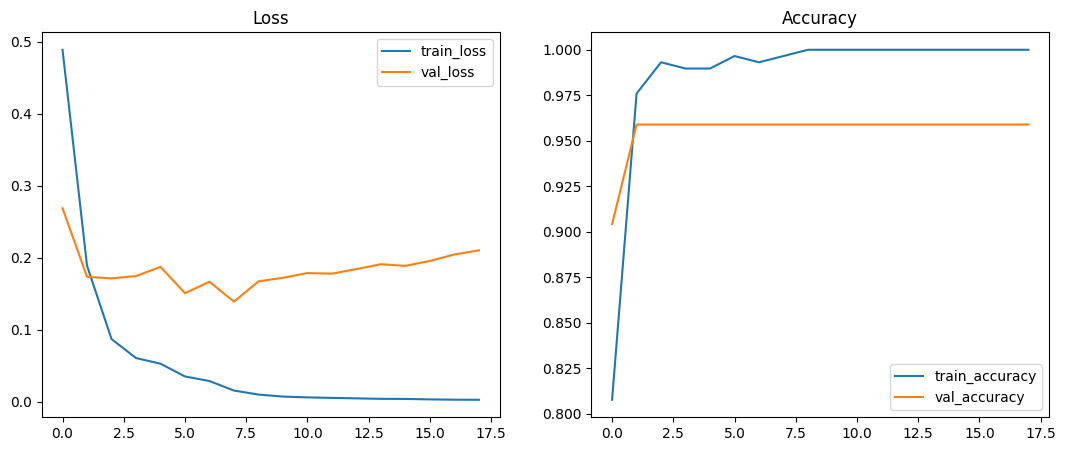

In [20]:
# Plot loss dan accuracy dalam satu gambar
plt.figure(figsize=(13, 5))

# Subplot untuk Loss
plt.subplot(1, 2, 1) 
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

# Subplot untuk Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [21]:
loss, accuracy = model.evaluate(test_dataset.batch(8))
print("Akurasi:", accuracy)
print("Loss:", loss)

10/10 [==============================] - 3s 128ms/step - loss: 0.1389 - accuracy: 0.9589
Akurasi: 0.9589040875434875
Loss: 0.13888391852378845


In [22]:
predictions = model.predict(test_dataset.batch(8))
predicted_classes = tf.argmax(predictions.logits, axis=1)

10/10 [==============================] - 5s 124ms/step


In [23]:
 target_names = ['positive', 'negative']
 print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.92      1.00      0.96        33
    negative       1.00      0.93      0.96        40

    accuracy                           0.96        73
   macro avg       0.96      0.96      0.96        73
weighted avg       0.96      0.96      0.96        73



In [24]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    
    # Menggunakan cmap tanpa nilai bawaan
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 0})

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Menambahkan nilai FN, TN, TP, FP di dalam heatmap
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j + 0.5, i + 0.5, f'{cm[i, j]:,}', ha='center', va='center', color='black', fontsize=12)

    plt.show()

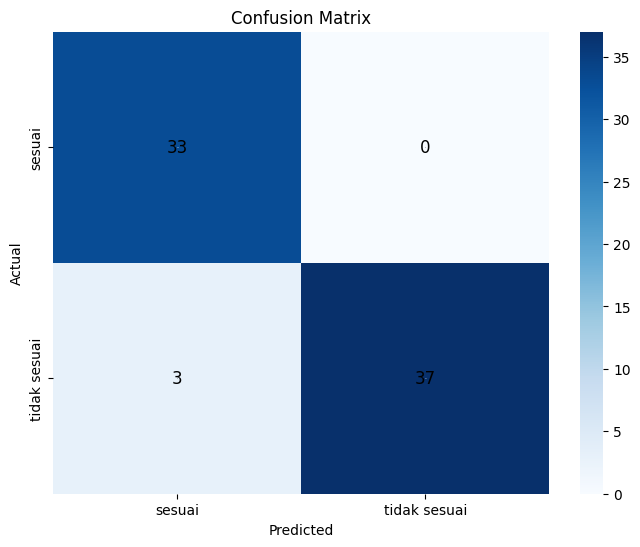

In [25]:
plot_confusion_matrix(y_test, predicted_classes, labels=['sesuai', 'tidak sesuai'])